## Les méthodes de délimitation du programme ZuPer

Ce notebook a pour but d'expliquer les différentes méthodes de délimitation pour calculer les aires d'alimentation. Il listera chaque méthode qui sont trouvable dans le programme ZuPer

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import ifm as ifm
import geone as gn
import geopandas as gpd
import scipy as sp
from scipy import interpolate
from scipy.integrate import solve_ivp
from scipy.optimize import root_scalar
from shapely.geometry import Polygon
from scipy.optimize import minimize

class zuper:

    doc = ''
    
    #####################
    # Instance variable #
    #####################
    
    def __init__(self, url_file):
        
        #get feflow file
        self.doc = ifm.loadDocument(url_file)

data = zuper(r'C:\zuper\final_case.fem')

doc = data.doc
nnodes = doc.getNumberOfNodes()
nelements = doc.getNumberOfElements()
x, y = np.zeros((nnodes,)), np.zeros((nnodes,))
for i in range(nnodes):
    x[i] = doc.getX(i)
    y[i] = doc.getY(i)

xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
dx = x[1] - x[0]
nbx_el = int(np.round( (xmax - xmin)/dx ))
dy = y[0] - y[nbx_el + 1]
nby_el = int(np.round( (ymax - ymin)/dy ))
s = dx*dy
nbx_nd, nby_nd = nbx_el + 1, nby_el + 1
ox, oy = doc.getOriginX(), doc.getOriginY()
qw = float( str( doc.createWellManager().getWells()[0].getPropertyValue(8) ).split('[')[0] )
xw = int(float(str( doc.createWellManager().getWells()[0].getPropertyValue(3)).split(' ')[0]))
yw = int(float(str( doc.createWellManager().getWells()[0].getPropertyValue(4)).split(' ')[0]))
for i in range(nnodes):
    if int( x[i] ) == xw and int( y[i] ) == yw:
        id_well = i

x.shape = (nby_nd, nbx_nd)
y.shape = (nby_nd, nbx_nd)

for i in range(nby_nd):
    for j in range(nbx_nd):
        if int(x[i][j])==xw and int(y[i][j])==yw:
            id_well_mesh = [i,j]

cov_mod = gn.covModel.CovModel2D([('spherical', {'w':0.25, 'r':[1300, 1300]})], 0, 'title')

def simulation_sgs(nx, ny, x, v, mu, std, seed=None):
    if x is None:
        return gn.geosclassicinterface.simulate2D(cov_mod, (nx, ny), (dx, dy), (ox, oy), x = np.array([[61, 244]])*np.array([dx, dy]), v = [2.5], mean=mu, var=std**2, seed=seed, verbose=0)['image'].val[0][0]
        
    return gn.geosclassicinterface.simulate2D(cov_mod, (nx, ny), (dx, dy), (ox, oy), x = x*np.array([dx,dy]), v = v, mean=mu, var=std**2, seed=seed, verbose=0)['image'].val[0][0]

def get_params():    
    k_matrix = simulation_sgs(nbx_nd, nby_nd, np.array([[61, 244]]), [2.5], 1.8, 0.35, seed=8948474)
    k_matrix_el = k_matrix[:nby_el, :nbx_el]
    k_mean = gmean(k_matrix, axis=None)
    
    r_matrix = simulation_sgs(nbx_nd, nby_nd, np.array([[61, 244]]), [401.5], 400, 15, seed=7528660)
    r_matrix_el = r_matrix[:nby_el, :nbx_el]
    r_mean = np.mean(r_matrix, axis=None)/365/1000

    b = doc.getParamValue(108, 0) - doc.getParamValue(106, 0)
    f = doc.getParamValue(201, 0)

    return k_matrix, k_matrix_el, k_mean, r_matrix, r_matrix_el, r_mean

k_matrix, k_matrix_el, k_mean, r_matrix, r_matrix_el, r_mean = get_params()

dict_params = {'recharge':r_matrix/365/1000}
dict_results = {}

def get_results(name_res=['charge', 'age', 'exit-time', 'probabilities']):
    var = 1
    for name in name_res:
        if name=='charge':
            dict_results[name] = np.array([ doc.getResultsFlowHeadValue(i) for i in range(nnodes) ])
            dict_results[name].shape = (nby_nd, nbx_nd)

        elif name in ['age', 'exit-time', 'probabilities']:
            doc.setMultiSpeciesId(var)
            dict_results[name] = np.array([ doc.getResultsTransportMassValue(i) for i in range(nnodes) ])
            dict_results[name][ dict_results[name]<0 ] = 0
            dict_results[name].shape = (nby_nd, nbx_nd)
            var+=1

    dict_results['contributions'] = dict_results['probabilities'] * dict_params['recharge'] * s

get_results()
print("Contributions = ",dict_results['contributions'])

Contributions =  [[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.44410646e-12
  1.23053553e-12 7.16492666e-13]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.31016702e-12
  1.15882486e-12 6.91057188e-13]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.14077369e-12
  1.07064276e-12 6.55690559e-13]
 ...
 [0.00000000e+00 1.74645682e-68 0.00000000e+00 ... 0.00000000e+00
  4.95469222e-67 0.00000000e+00]
 [1.22184168e-69 0.00000000e+00 4.76088154e-69 ... 7.97569166e-68
  0.00000000e+00 3.54610008e-68]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


-----------------------------------------------------------------------------------------------------------------------------------------------------------

#### La méthode standard

La méthode standard est une méthode développée par Monsieur Thierry Bussard, qui a développé une méthodologie pour définir les aires d'alimentation en Suisse. Cette méthode se base sur le calcul d'un ensemble de valeur (appelé champ) qui contient les contributions de chaque partie d'un bassin d'alimentation. Ce bassin est toute portion de terrain, constitué d'une partie sédimentaire (sédiments meubles comme du gravier ou du sable) et d'une partie non-sédimentaire (fractures dans la roche mère ou conduits karstiques), où de l'eau circule au travers du sol et alimente un puits de captage ou une source.

Le calcul des contributions se fait de la manière suivante :

<br><center>$S_{c} = \sum_{i=1}^{N} c_{i}$</center><br>

Où $c_{i}$ est la i-ème contribution du bassin d'alimentation, $N$ le nombre de partie du bassin d'alimentation et $S_{c}$ la contribution cumulée.

La condition pour cumulée les contributions est la suivante : Il faut pouvoir prendre la contribution de la plus grande à la plus petite. Cela s'écrit ainsi :

<br><center>$c_{i} \ge c_{i+1}$</center></br>

Chaque contribution est calculé à partir de deux paramètres : la recharge en eau souterraine (r), la probabilité de capture (p) et la surface d'une partie du bassin d'alimentation (s). Dans le programme ZuPer, la recharge est défini soit de manière aléatoire avec la simulation gaussienne séquentielle, soit de manière constante avec une valeur définie comme référence ($f(x,y)$). La probabilité de capture est défini à partir des simulations numériques produites avec le logiciel Feflow ($F_{w}(x,y)$). La surface quand à elle est obtenue en multipliant l'espace entre deux noeuds selon l'axe x ($d_{x}$) et selon l'axe y ($d_{y}$). Cela se résume ainsi :

<br><center>$c = rsp$</center>

<br><center>$r = f(x,y)$</center>

<br><center>$s = d_{x}d_{y}$</center>

<br><center>$p = F_{w}(x,y)$</center>

Nous voyons donc bien que le résultat obtenue pour les contributions sont bien une collection de données sois sous forme vectoriel, soit sous forme matricielle. Dans le cas théorique fait de vecteurs, la multiplication se fait par le produit scalaire ($c = r \cdot p \cdot s$). Dans l'autre cas théorique avec des matrices, le produit de Hadamard ou de Schur est nécessaire ($c = r \circ p \circ s$). Avec le programme ZuPer, le calcul des contributions se fait contribution après contribution (voir boucle for) où chaque contribution est cumulée et dont l'indice est stocker dans une autre variable pour délimiter l'aire d'alimentation.

La méthode contient aussi un argument qui est noté $\Pi$, correspondant à la fraction du débit du puits de captage. Il permet de tester ce que la variation du débit du puits peut impacter sur la forme et la délimitation des aires d'alimentation. On définit donc un nouveau débit ($Q^{'}$) de la manière suivante :

<br><center>$Q^{'} = \Pi Q_{w}~~||~~\Pi \in [0 ; 1]$</center></br>

La variable $z$ stocker les noeuds devant appartenir à l'aire d'alimentation.

Voyons maintenant un exemple. La fonction suivante permet le calcul de l'aire d'alimentation selon la méthode standard :

In [13]:
def standard_method(PI):
    # take contributions values
    c = dict_results['contributions'].flatten()
    
    # quicksort algorithm used to sort contributions values
    index = np.argsort(c)[::-1]
    
    # create the zu zone variable
    z = np.zeros((nnodes,))
    
    # define the res variable to stock results of contributions
    res = 0
    
    # define the limits of contributions and the tau variable
    PI_LIM = PI*qw
    tau=0
    
    # for loop to determine which nodes are usefull to determine the Zu zone
    for i in index:
        res+=c[i]
        z[i] = 1
        tau+=1
        if res>=PI_LIM:
            break;
    
    z.shape = (nby_nd, nbx_nd)
    dict_results['zu'] = z

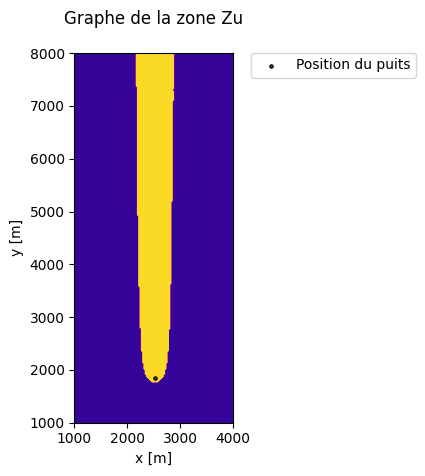

In [85]:
standard_method(0.8)

plt.figure()
plt.contourf(x,y,dict_results['zu'], cmap='plasma')
plt.scatter(xw, yw, s=5, edgecolors='black')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title("Graphe de la zone Zu\n")
plt.axis([xmin, xmax, ymin, ymax])
plt.gca().set_aspect('equal', adjustable='box')
plt.xticks((1000, 2000, 3000, 4000))
plt.legend(['Position du puits'], bbox_to_anchor=(2.2,1.02))
plt.show()

#### La méthode meanlife

La méthode meanlife est une de méthode de délimitation pour les aires d'alimentation. Proposée et utilisée dans le travail de Master de Daniel Borel-Jaquet, cette méthode est une alternative à la condition de la somme des valeurs de contributions du bassin d'alimentation. La nouvelle condition est la suivante : 

<br><center>$c_{e_{i}} < c_{e_{i+1}}$</center>

où $c_{e_{i}}$ la i-ème valeur de contribution selon la i-ème valeur de temps de sortie, et $i$ un nombre entier parcourant le nombre de noeud du maillage.

Cela signifie que les contributions sont ordrées selon les valeurs de temps de sorties (exit-time) de la plus petite à la plus grande. Nous essayons d'avoir avec cette méthode le chemin de parcourt le plus petit amenant un certain taux de contributions d'eau souterraine. L'ordre se fait avec l'algorithme "Quicksort".

Après avoir fait la somme des contributions, comme avec la méthode standard, la délimitation de la zone Zu est possible. Cette délimitation peut se faire selon différentes valeurs du débit du puits (noté <b>PI_LIM</b>) :

<br><center>$Q^{'} = \Pi Q_{w}~~||~~\Pi \in [0 ; 1]$</center></br>

avec $Q$ le débit du puits.

In [23]:
def meanlife_method(PI):
    # take capture probabilities, exit-time and contributions values
    p, e, c = dict_results['probabilities'].flatten(), dict_results['exit-time'].flatten(), dict_results['contributions'].flatten()
    
    # create the zu zone variable
    z = np.zeros((nnodes,))
    
    # quicksort algorithm used to sort exit-time values
    ind_e = np.argsort(e)
    
    # define the res variable to stock results of contributions
    res = 0
    
    # define the limits of contributions
    PI_LIM = PI * qw

    # instance the results and tau variable
    res+=c[id_well]
    z[id_well] = 1
    tau=1

    # for loop to determine which nodes are usefull to determine the Zu zone
    for i in ind_e:
        if e[i]!=0 and p[i]>0.01:
            res+=c[i]
            z[i] = 1
            tau+=1
            if res>=PI_LIM:
                break;

    # calculate the differents coefficients of the Zu zone
    z.shape = (nby_nd, nbx_nd)
    dict_results['zu'] = z

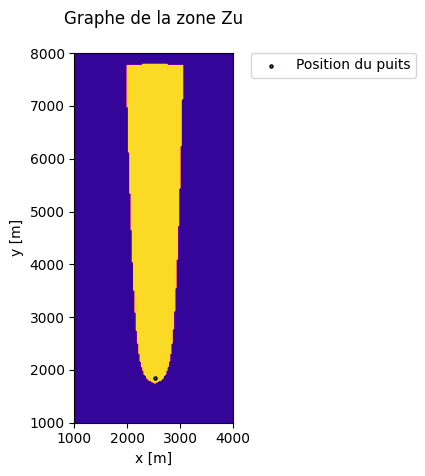

In [86]:
meanlife_method(0.8)

plt.figure()
plt.contourf(x,y,dict_results['zu'], cmap='plasma')
plt.scatter(xw, yw, s=5, edgecolors='black')
plt.legend(['Position du puits'], bbox_to_anchor=(2.2,1.02))
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title("Graphe de la zone Zu\n")
plt.axis([xmin, xmax, ymin, ymax])
plt.gca().set_aspect('equal', adjustable='box')
plt.xticks((1000, 2000, 3000, 4000))
plt.show()

#### La méthode basique ou CFR

La méthode CFR est une méthode simpliste pour délimiter une aire à protéger. Elle consiste à calculer un rayon qui est utilisée pour délimiter un disque autour du puits. En prenant en compte un équilibre des masses d'eau entrant et sortant du sol où le puits se situe, on définir alors le rayon par l'équation suivante :

<br><center>$r = \frac{Q_{w}}{\pi R}$</center></br>

où $Q_{w}$ est le débit du puits et $R$ est le taux de recharge en eau souterraine.

Pour définir cette aire, on utilise l'équation algébrique du disque qui est la suivante :

<br><center>$\sqrt{(x - x_{w})^{2} + (y - y_{w})^{2}} < r$</center></br>

avec $x$ et $y$ les coordonnées du maillage, $x_{w}$ et $y_{w}$ les coordonnées du puits dans le maillage, $r$ le rayon calculé.

Cette délimitation peut se faire selon différentes valeurs du débit du puits (noté <b>PI_LIM</b>) :

<br><center>$Q^{'} = \Pi Q_{w}~~||~~\Pi \in [0 ; 1]$</center></br>

avec $Q_{w}$ le débit du puits.

In [31]:
def cfr_method(PI):
    # determine the radius
    r = np.sqrt( (qw*PI) / (np.pi*r_mean) )
    
    # determine the zu zone by the circle formula with the previous calculated radius
    d = np.sqrt((x - xw)**2 + (y - yw)**2) < r
    
    tau = np.unique(d, return_counts=True)[1][1]
    a_zu = round(tau*s/10000,2)
    
    # switch boolean value into integers values for the zu zone
    d = d.astype(float)
    
    # resize the d variable 
    d.resize(nby_nd, nbx_nd)
    
    # put the zu zone in the results dictionnary
    dict_results['zu'] = d

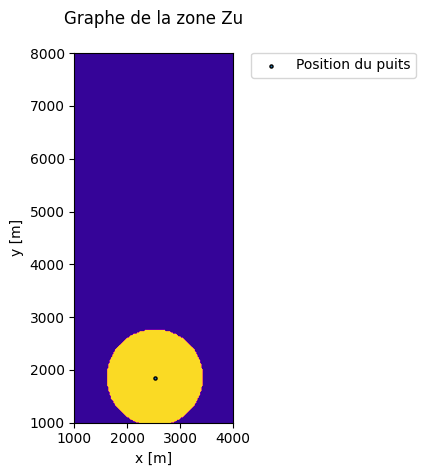

In [87]:
cfr_method(0.8)

plt.figure()
plt.contourf(x,y,dict_results['zu'], cmap='plasma')
plt.scatter(xw, yw, s=5, edgecolors='black')
plt.legend(['Position du puits'], bbox_to_anchor=(2.2,1.02))
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title("Graphe de la zone Zu\n")
plt.axis([xmin, xmax, ymin, ymax])
plt.gca().set_aspect('equal', adjustable='box')
plt.xticks((1000, 2000, 3000, 4000))
plt.show()

#### La méthode de Lerner

La méthode de Lerner représente ce qu'on appelle la solution semi-analytique de Lerner. Le principe est de calculer un champs de valeurs de vitesse des particules d'eau souterraine, puis de définir un champ de position des particules d'eau en intégrant le champ de vitesse et ainsi définir une aire à protéger. Cet aire est appelé en général "zone de capture".

Pour commencer, le champ de vitesse est défini ainsi :

<br><center>$\frac{dx}{dt} = V_{x}~~\frac{dy}{dt} = V_{y}$</center></br>

Ces champs de vitesse ont une composante représentant la recharge en eau, et une autre composante représentant le flux d'eau régional. Plusieurs hypothèses sont faites :

<ul>
    <li>Épaisseur constante de l'aquifère</li>
    <li>Porosité homogène et isotrope</li>
    <li>Aquifère confiné et poreux</li>
    <li>Transmissivité et recharge homogène et isotrope</li>
</ul>

Comme dans l'article de Lerner (https://doi.org/10.1029/92WR01170) il existe deux situations présentée, nous allons utiliser le second exemple comprenant une barrière imperméable dans le maillage. Les champs de vitesses sont les suivants :

<br><center>$v_{xr} = \frac{Rx}{bn}~~v_{yr} = 0$</center></br>

avec $R$ le taux de recharge en eau, $x$ et $y$ les coordonnées du maillage, $b$ l'épaisseur de l'aquifère, $n$ la porosité effective. Par la suite, Lerner utilise pour définir la charge hydraulique une équation mathématique proposé par Muskat en 1937 et qui est trouvable dans l'article de Lerner. En définissant un nouveau champ de vitesse au niveau du puits par une forme d'équation de Darcy et par l'équation de la charge hydraulique de Muskat, on peut calculer le champ global des vitesses de la manière suivante :

...

Puis en utilisant la méthode de Raphson-Newton (obtenable sur Python avec la méthode solver_ivp du module <u>Scipy</u>), nous pouvons résoudre l'équation différentielle qui est la suivante pour obtenir le champ de vitesse :

<br><center>$v_{x} = \frac{Rx}{bn} - \frac{Q}{2abn} \left( \frac{1}{sin(x^{-})} + \frac{1}{sin(x^{+})} \right) = 0$</center></br>

Enfin, pour définir les noeuds compris dans la surface à protéger, il faut pouvoir calculer une intégrale de manière numérique de la façon suivante :

<br><center>$\int_{a}^{b} \int_{c}^{d}~~1_A(x, y)~~dx,dy$</center></br>

où $a$, $b$, $c$, $d$ sont les valeurs minimales et maximales des axes x et y, $1_A(x, y)$ la fonction indicatrice pour définir les noeuds à prendre en compte pour la délimitation de la zone Zu.

Cette délimitation peut se faire selon différentes valeurs du débit du puits (noté <b>PI_LIM</b>) :

<br><center>$Q^{'} = \Pi Q_{w}~~||~~\Pi \in [0 ; 1]$</center></br>

avec $Q_{w}$ le débit du puits.

In [47]:
def lerner_method(PI):
    # Initiate all parameters that Lerne's solution need to work :
    # R=mean recharge ; b=thickness of aquifer ; T=transmissivity ; n=porosity
    # Q=discharge of well ; xw and yw=position of well in the matrix mesh
    # xmin, xmax, ymin, ymax=minimum and maximum of x-axis and y-axis respectively
    # a = the length of the aquifer ; nx, ny=number of nodes of x-axis and y-axis in the mesh
    R = r_mean
    b = 100
    T = k_mean
    poro = 0.3
    Q = PI*qw 
    #xw, yw = xw, yw
    #xmin, xmax = xmin, xmax
    #ymin, ymax = ymin, ymax
    a = (ymax - ymin) 
    nx = nbx_nd
    ny = nby_nd
    
    # define axis vector in the mesh
    xv = np.linspace(xmin,xmax,nx)
    yv = np.linspace(ymin,ymax,ny)
    xx, yy = np.meshgrid(xv, yv)
    
    # define the parameter for the size of calculation
    xl = ymax - yy
    yl = xx 
    xlw = ymax - yw
    ylw = xw
    
    # define the initial velocity in x-axis and y-axis for calculation
    vxlr = R * xl / (b * poro)
    vylr = 0
    
    # define the limit of y
    ym = np.pi * (yl - ylw) / (2 * a)
    
    # function of calculation of velocity in x-axis
    def Ux(xp):
        xm = np.pi * (xl - xp) / (2 * a)
        xp = np.pi * (xl + xp) / (2 * a)
    
        return - Q / (8 * a * b * poro) * ( np.sin(xm) / (np.cosh(ym) - np.cos(xm)) +
                                    np.sin(xp) / (np.cosh(ym) + np.cos(xp)))
    
    # function of calculation of velocity in x-axis
    def Uy(xp):
        xm = np.pi * (xl - xp) / (2 * a)
        xp = np.pi * (xl + xp) / (2 * a)
    
        return   - Q * np.sinh(ym) / (8 * a * b * poro) * ( 1 / (np.cosh(ym) - np.cos(xm)) +
                                                1 / (np.cosh(ym) + np.cos(xp))) 
    
    # use of well image to calculate velocity from the well
    vxlw = Ux(xlw) + Ux(-xlw)
    vylw = Uy(xlw) + Uy(-xlw)
    
    vxl = vxlr + vxlw
    vyl = vylr + vylw
    
    vx = vyl
    vy = - vxl
    
    # function use to define the equation needed to be resolve
    def f(x):
        xm = np.pi * (x - xlw) / ( a)
        xp = np.pi * (x + xlw) / ( a)
        return R * x / (b * poro) - Q / (2 * a * b * poro) * (1 / np.sin(xm) - 1 / np.sin(xp))
    
    # parameter of differential used in the resolution of the differential equation
    eps = 0.1
    res = root_scalar(f, bracket=[xlw + eps, a])
    xls = res.root
    xs = xw
    ys = ymax - xls

    # function to determine the velocity field
    def vxy(t, pos):
        # calculate initial variables (position, mesh) 
        x, y = pos
        xl = ymax - y
        yl = x
        xlw = ymax - yw
        ylw = xw
        ym = np.pi * (yl - ylw) / (2 * a)

       # return the velocity field for the x-axis (Ux) and y-axis (Uy)
        def Ux(xk):
            xm = np.pi * (xl - xk) / (2 * a)
            xp = np.pi * (xl + xk) / (2 * a)
            return - Q / (8 * a * b * poro) * ( np.sin(xm) / (np.cosh(ym) - np.cos(xm)) +
                                    np.sin(xp) / (np.cosh(ym) + np.cos(xp)))
    
        def Uy(xk):
            xm = np.pi * (xl - xk) / (2 * a)
            xp = np.pi * (xl + xk) / (2 * a)
            return - Q * np.sinh(ym) / (8 * a * b * poro) * ( 1 / (np.cosh(ym) - np.cos(xm)) +
                                                1 / (np.cosh(ym) + np.cos(xp))) 

        # use image well theory to determine the true velocity field
        vx = Uy(xlw) + Uy(-xlw)
        vy = - Ux(xlw) - Ux(-xlw)  - R * xl / (b * poro)

        # return the results
        return [-vx, -vy]
    
    # resolve the differential equation with Newton-Ralphson method
    sol = solve_ivp(vxy, [0, 1e6], [xs + 30*eps, ys], max_step = 50)
    
    # get values of resolution
    ybound = sol.y[1] 
    xrightbound = sol.y[0]
    xleftbound = 2 * xw - xrightbound
    
    # define a mesh and interpolate the function for discretisation method
    cx = np.linspace(xmin, xmax, nx)
    cy = np.linspace(ymin, ymax, ny)
    dx = (xmax-xmin)/nx
    xx, yy = np.meshgrid(cx, cy)
    capture = np.zeros(yy.shape)
    f = interpolate.interp1d(ybound, xleftbound)
    
    # For loop to integrate the Lerner solution with a discretisation
    # method from the bottom to the top of model
    for M in range(ny):
        xcurent = yy[M,0]
        if xcurent < ybound[0]:
            continue
        elif xcurent > ybound[-1]:
            continue
        else:
            ytop = f(xcurent)
            jtop = int( (ytop-xmin)/dx)
            jbot = -jtop
            capture[M, jtop:jbot] = 1
        
    # keep Zu zone in "dict_results" and determine coefficients (efficiency and surface)
    dict_results['zu'] = capture[::-1].copy()
    dict_results['zu'].shape = (nby_nd, nbx_nd)
    tau = np.unique(capture[::-1].copy(), return_counts=True)[1][1]

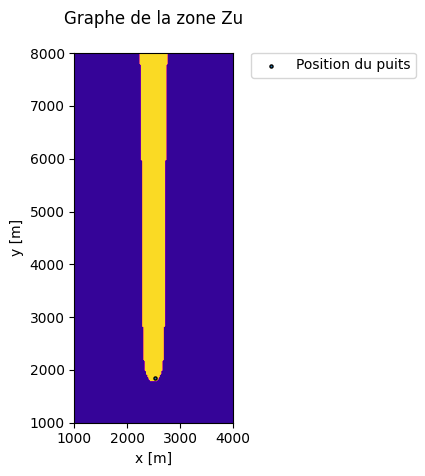

In [88]:
lerner_method(0.8)

plt.figure()
plt.contourf(x,y,dict_results['zu'], cmap='plasma')
plt.scatter(xw, yw, s=5, edgecolors='black')
plt.legend(['Position du puits'], bbox_to_anchor=(2.2,1.02))
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title("Graphe de la zone Zu\n")
plt.axis([xmin, xmax, ymin, ymax])
plt.gca().set_aspect('equal', adjustable='box')
plt.xticks((1000, 2000, 3000, 4000))
plt.show()

#### La méthode de Bear-Jacobs

La solution analytique de Bear-Jacobs, nommée ici méthode de Bear-Jacobs, est une méthode utilisé pour tenter de délimiter une zone de capture à protéger. Proposé en 1965 par Martin Jacobs et Jacob Bear (https://doi.org/10.1016/0022-1694(65)90065-X), elle consiste en une équation mathématique résolvable dans un régime transitoire :

<br><center>$e^{x - t} = cos(y) + \frac{x}{y}sin(y)$</center></br>

où $x$ et $y$ sont les coordonnées du maillage et $t$ une constante choisie au départ représentant le temps de parcourt de l'eau dans le sol. Cette équation peut se résoudre de manière algébrique en utilisant la fonction de Lambert et en simplifiant la forme de l'équation de base.

Dans la fonction de base, elle essaie de tester différents valeurs de temps, signifiant alors de trouver une valeur de $t$ caractéristique au 90% du débit du puits (soit à la surface de l'aire d'alimentation selon la méthode standard). On utilise une méthode de minimisation des erreurs trouvable dans le module <u>Scipy</u> et défini la position de la zone de capture à partir d'une approximation formant un polygone (module Polygon avec la méthode shapefile.geometry). Ceci donne alors une liste de coordonnées de la zone de capture, puis une intégrale numérique (comme avec la méthode de Lerner) :

<br><center>$\int_{a}^{b} \int_{c}^{d}~~1_A(x, y)~~dx,dy$</center></br>

où $a$, $b$, $c$, $d$ sont les valeurs minimales et maximales des axes x et y, $1_A(x, y)$ la fonction indicatrice pour définir les noeuds à prendre en compte pour la délimitation de la zone Zu.

Cette délimitation peut se faire selon différentes valeurs du débit du puits (noté <b>PI_LIM</b>) :

<br><center>$Q^{'} = \Pi Q_{w}~~||~~\Pi \in [0 ; 1]$</center></br>

avec $Q_{w}$ le débit du puits.

In [61]:
def bear_jacobs_method(PI):
    #y=np.linspace(-np.pi,np.pi,100)
    
    def x_bear_jacob(y,t,k=0):
        a=np.cos(y)
        b=np.sin(y)/y
        c=np.exp(-t)
        x=-a/b - sp.special.lambertw(-c/(b*np.exp(a/b)),k=k)
        
        if x.imag==0:
            return x.real
        else:
            return 9999
    
    def bear_jacob(t,n_point=1000):
        Y_0=np.linspace(-np.pi+0.1,np.pi-0.1,n_point)
        Y_1=np.linspace(-np.pi+0.1,np.pi-0.1,n_point)
        X_0=np.zeros(n_point)
        X_1=np.zeros(n_point)
        for i in range(len(Y_0)):
            X_0[i]=x_bear_jacob(Y_0[i],t)
            X_1[i]=x_bear_jacob(Y_1[i],t,k=-1)
        
        X=np.concatenate((X_0,X_1[::-1]))
        Y=np.concatenate((Y_0,Y_1[::-1]))
        
        return X[X!=9999],Y[X!=9999]
    
    def changement_coordonnées(X,Y,xw,yw):
        new_x=-Y+xw
        new_y=X+yw
        
        return new_x,new_y
    
    def full_bear_jacob(t,q0,Qi,n,xw,yw,n_point=1000):
        tb=2*np.pi*(q0**2)*t/n/Qi
        xb,yb=bear_jacob(tb,n_point=n_point)
        x=xb*Qi/2/np.pi/q0
        y=yb*Qi/2/np.pi/q0
        
        return changement_coordonnées(x,y,xw,yw)
    
    def bear_and_jacobs_opti(t,Q,xi,Recharge,gdf_coord):
        return abs(bear_and_jacobs_recharge(t,Q,Recharge,gdf_coord)-Q*xi)
    
    def bear_and_jacobs_recharge(t,Q,Recharge,gdf_coord):
        t=t[0]
        resx,resy=full_bear_jacob(t=t,q0=r_mean/86400 * s * nnodes,Qi=Q,n=0.2,xw=xw,yw=yw,n_point=1000)
        Poly_zu=Polygon(zip(resx,resy))
    
        Zu=gdf_coord.within(Poly_zu)
        Rf=Recharge.flatten()
        return np.sum(Rf[Zu])
    
    def bear_and_jacobs_ZU(Q,xi,Recharge):
        dd = {'X':x.flatten().copy(), 'Y':y.flatten().copy()}
        
        dataf = gpd.GeoDataFrame(dd, geometry=gpd.points_from_xy(dd['X'], dd['Y']))
        
        x0=[3e6]
        opti=minimize(bear_and_jacobs_opti,x0,args=(Q,xi,Recharge,dataf), method='Nelder-Mead')
        resx,resy=full_bear_jacob(t=x0[0],q0=r_mean /86400 *s *nnodes/3000, Qi=Q*xi, n=0.2, xw=xw, yw=yw, n_point=1000)
        Poly_zu=Polygon(zip(resx,resy))
    
        Zu=dataf.within(Poly_zu)
    
        return Zu
    
    # solve the bear-jacobs equation
    Zu = bear_and_jacobs_ZU(qw/86400, PI, dict_params['recharge']/86400)
    zzz = Zu.values
    
    # if condition to determine if we have True values after delimitation
    if True in zzz:
        tau = np.unique(zzz, return_counts=True)[1][1]
    
    else:
        tau = 0
    
    # Define coefficients (efficiency, surface of Zu zone) and keep Zu matrix in "dict_results"
    zzz = zzz.astype(float)
    zzz.resize(287, 123)
    dict_results['zu'] = zzz

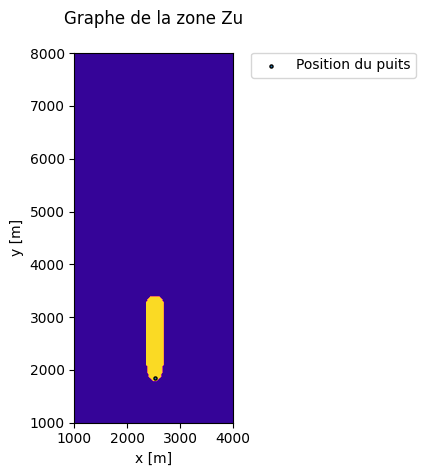

In [89]:
bear_jacobs_method(0.8)

plt.figure()
plt.contourf(x,y,dict_results['zu'], cmap='plasma')
plt.scatter(xw, yw, s=5, edgecolors='black')
plt.legend(['Position du puits'], bbox_to_anchor=(2.2,1.02))
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title("Graphe de la zone Zu\n")
plt.axis([xmin, xmax, ymin, ymax])
plt.gca().set_aspect('equal', adjustable='box')
plt.xticks((1000, 2000, 3000, 4000))
plt.show()

## Choisir une méthode spécifique

Cette fonction est un regroupement de toutes les méthodes de délimitation utilisés dans le travail de Daniel Borel-Jaquet. Elle contient 2 arguments de fonction pour choisir la méthode de délimitation :

<ul>
    <li>method : chaîne de caractère représentant le nom de code pour la-dite méthode de délimitation</li>
    <li>PI : nombre réel représentant le pourcentage de débit du puits</li>
</ul>

In [6]:
def choose_method(self, method, PI):
    # Method to choose by "method" argument, and use all 
    # parameters of the method chosen found in "list_params_method".
    if method=='standard':
        self.standard_method(PI)

    elif method=='meanlife':
        self.meanlife_method(PI)

    elif method=='cfr':
        self.cfr_method(PI)
    
    elif method=='lerner':
        self.lerner_method(PI)
        
    elif method=='bear-jacobs':
        self.bear_jacobs_method(PI)